In [3]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
import ast
import emcee
import corner
import seaborn as sns

# PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Get the data

In [4]:
# Load the saved array - gives Boost(i = sample point, z, k)
Bk_arr = np.load('Boost.npy')
print(Bk_arr.shape)

(50, 51, 768)


In [5]:
# extract data from text file - gives z and k arrays
txt_arr = np.loadtxt("z_k.txt")

z_arr = np.array(txt_arr.T[0][np.isfinite(txt_arr.T[0])])
k_arr = np.array(txt_arr.T[1])

print(z_arr.shape)
print(k_arr.shape)

(51,)
(768,)


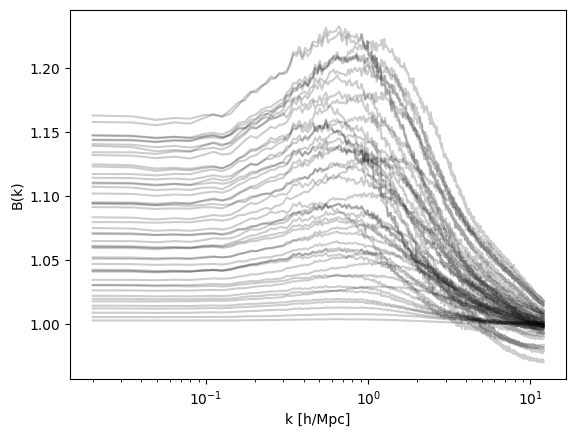

In [6]:
# Plot data

z_index = 12

plt.figure(32)
for sim_index in range(49):
    plt.plot(k_arr, Bk_arr[sim_index, z_index, :], 'k', alpha=0.2)
    

plt.ylabel("B(k)")
plt.xlabel("k [h/Mpc]")
plt.xscale('log')
plt.show()
     


In [7]:
# Get the parameter - for now assume only one parameter, w_m
txt = "cosmo_newdesign"
hcube = np.loadtxt(txt).T
f_phi = hcube[4]
h = hcube[3]
Omega_m = hcube[0]
n_s = hcube[1]
A_s = hcube[2]

theta_1 = np.array(hcube)

"""
    wb = 0.0223
    wr = 4.28e-5
"""


'\n    wb = 0.0223\n    wr = 4.28e-5\n'

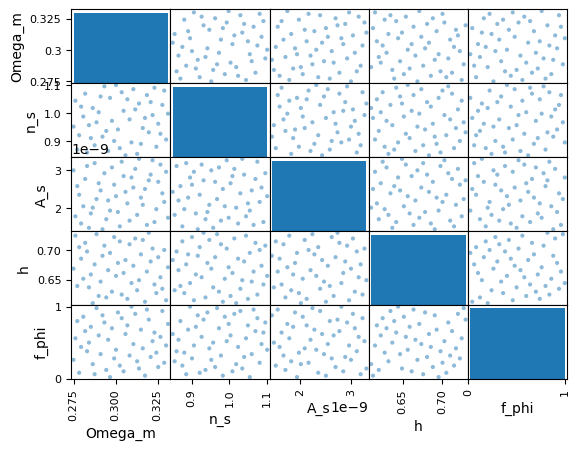

In [8]:
df_theta = pd.DataFrame(theta_1.T, columns=['Omega_m','n_s', 'A_s', 'h', 'f_phi'][:len(theta_1)])
pd.plotting.scatter_matrix(df_theta)
plt.show()


## Create the emulator

In [9]:
# Useful functions to define

"""Functions for GP conditional distributions"""

# Define the Squared Exponential (SE) covariance function
def SE_kernel(xa, xb, standard_dev, lengthscale):
    
    """Exponentiated quadratic
    xa --> (ma, n), where ma is the number of gaussian vectors (n points in function)
                    and n is the dimension of the vector theta
    xb --> (mb, n)
    standard_dev --> standard deviation of function
    lengthscale --> characteristic length scale"""
    
    # Squared of Euclidian distance [Dist_{a,b} = xa - xb]
    
    
    sq_norm = -0.5 * (scipy.spatial.distance.cdist(xa/lengthscale, xb/lengthscale, 'euclidean') **2)
    return standard_dev**2 * np.exp(sq_norm)

# Gaussian process posterior with no noise
def GP(X1, y1, X2, kernel_func):
    """
    Calculate the posterior mean and covariance matrix for y2
    based on the corresponding input X2, the observations (y1, X1), 
    and the prior kernel function.
    """
    # Kernel of the observations
    K11 = kernel_func(X1, X1)
    # Kernel of observations vs to-predict
    K12 = kernel_func(X1, X2)
    # Solve - returns (K11^-1 * K12)^T, assuming positive definite solutions
    solved = scipy.linalg.solve(K11, K12, assume_a='pos').T
    # Compute posterior mean
    mean2 = solved @ y1
    # Compute the posterior covariance
    K22 = kernel_func(X2, X2)
    K2 = K22 - (solved @ K12)
    return mean2, K2  # mean, covariance

"""Functions for hyperparameter MCMC"""

# Find likelihood for given sigma, ell given theta, w_theta from simulations

def log_likelihood(theta, w_theta, params):
    """
    theta --> array (n_param, n_sim)
    w_theta --> array (n_sim, n_PCs)
    params: array [sigma1, ell1, sigma2, ell2, ...]
    """
    
    # Reshape the params array into a list of tuples [(sigma1, ell1), (sigma2, ell2), ...]
    params_tuple = [(params[i], params[i+1]) for i in range(0, len(params), 2)]

    n_PCs = w_theta.shape[1]
    
    if n_PCs != len(params_tuple):
        raise ValueError("Each pair of sigma and ell parameters should be provided in the params list.")
    
    lik_sum = 0
    for i in range(n_PCs):
        sigma, ell = params_tuple[i]
        
        # Define kernel function for current sigma and ell
        kernel_func = lambda x, y: SE_kernel(x, y, sigma, ell)
        
        # Sample observations (X1, y1) on the function
        X1 = theta.T
        y = w_theta.T[i].reshape(-1, 1)
        
        # Compute covariance matrix and its inverse
        covariance = kernel_func(X1, X1)
        inv_cov = np.linalg.inv(covariance)
        
        # Compute likelihood contribution for current parameter set
        lik_i = -0.5 * np.dot(np.dot(y.T, inv_cov), y) - 0.5 * np.log(np.linalg.det(covariance))
        
        lik_sum += lik_i[0][0]
    
    return lik_sum


def log_prior(params):
    """
    params: array [sigma1, ell1, sigma2, ell2, ...]
    """    
    # Check if the number of parameters is even
    if len(params) % 2 != 0:
        raise ValueError("Each pair of sigma and ell parameters should be provided in the params list.")
    
    # Reshape the params array into a list of tuples [(sigma1, ell1), (sigma2, ell2), ...]
    params_tuple = [(params[i], params[i+1]) for i in range(0, len(params), 2)]
    
    num_params = len(params_tuple)
    
    
    # Iterate over each pair of (sigma, ell) and check the range
    for i in range(num_params):
        sigma, ell = params_tuple[i]
        if not (-0.01 < sigma < 100 and -0.01 < ell < 10):
            return -np.inf
    return 0.0

def log_probability(params, theta, w_theta):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, w_theta, params)


In [26]:
"""Trains emulator by finding PCs/optimized hyperparameters for the input data"""

def B_k_emu_init(Bkarr , theta_arr , k , z=0.0):
    """
    Bkarr --> array (n_sim, n_k)
    theta_arr --> array (n_param, n_sim)
    k --> array (n_k)
    z --> float (default = 0.0)
    
    returns optimized hyperparameters
    """
    # STEP 1: standardization transformation
    
    theta = (theta_arr - np.mean(theta_arr, axis=1, keepdims=True)) / np.std(theta_arr, axis=1, keepdims=True)

    chi = (Bkarr - np.mean(Bkarr, axis=0)) / np.std(Bkarr, axis=0)

    # STEP 2: PCA (find components)
    
    Usvd, s, vh = np.linalg.svd(chi.T, full_matrices=True)
    Usvd = Usvd.T
    
    # Choose the number of components based on explained variance ratio
    pca = PCA(n_components=0.995)
    pca.fit(chi)
    idx = pca.n_components_
    print(idx)
    # get weights
    w_theta = np.matmul(chi, Usvd[:idx].T)

    # STEP 3: MCMC to get hyperparameters (sigma and ell)
    
    # Choose some initial parameter estimates
    initial_conditions = [3.0, 0.5] # Initial conditions for sigma and ell
    
    n_walkers = 70

    # Generate random numbers
    pos = 1e-2 * np.random.randn(*(n_walkers, int(2*idx))) + [initial_conditions * idx]
    
    # initializing the walkers in a tiny Gaussian ball and then run 1000 steps of MCMC    
    nwalkers, ndim = pos.shape
    
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_probability, args=(theta, w_theta)
    )
    sampler.run_mcmc(pos, 5000, progress=True);

    flat_samples = sampler.get_chain(discard=2000, thin=15, flat=True)
    
    return [Bkarr , theta_arr, theta, chi, Usvd, idx, w_theta, flat_samples]


In [27]:
"""Use the emulator to find the boost at a new set of parameters theta"""

def B_k_emu(init, theta_new_arr):
    """
    *boost*: Bkarr --> array (n_sim, n_k)
    *training dataset*: theta_arr --> array (n_param, n_sim)
    *standardized training dataset*: theta --> array (n_param, n_sim)
    *standardized boost*: chi --> array (n_sim, n_k)
    *PCA rotation matrix*: Usvd  --> array (n_k, n_k)
    *n_PCs*: idx --> float ( = n_hyperparams/2 )
    *weight for PCs*: w_theta --> array (n_sim, idx)
    *hyperparam chains*: flat_samples --> array (n_chains, n_hyperparams)
    *output dataset*: theta_new_arr --> array (n_param, n_2)
    
    returns Bk_new = Boost(theta_new_arr) --> array (n_2, n_k)
    """
    Bkarr , theta_arr, theta, chi, Usvd, idx, w_theta, flat_samples = init

    theta_new = np.zeros((len(theta_new_arr), len(theta_new_arr[0])))
    for i in range(len(theta)):
        theta_new[i] = (theta_new_arr[i] - np.mean(theta_arr[i]))/np.std(theta_arr[i])

    sigma = np.zeros(idx)  # one for each hyperparameter
    ell = np.zeros(idx)    # one for each hyperparameter
    
    for i in range(idx):
        sigma[i] = np.percentile(flat_samples[:, i*2], [16, 50, 84])[0]
        ell[i] = np.percentile(flat_samples[:, i*2 + 1], [16, 50, 84])[0]

    # STEP 4: Compute the posterior mean and covariance

    # Sample from the Gaussian process distribution

    n1 = len(theta[0])  # Number of points to condition on (training points)
    n2 = len(theta_new[0])  # Number of points in posterior (test points)

    mean_variance = []
    for i in range(idx):
        X1 = theta.T
        y1 = w_theta.T[i].reshape(-1, 1)

        X2 = theta_new.T

        # Compute posterior mean and covariance
        mean, variance = GP(X1, y1, X2, lambda x, y: SE_kernel(x, y, sigma[i], ell[i]))
        mean_variance.append((mean, variance))

    theta_emu = X2
    
    w_theta_emu_arr = np.array([mean_variance[i][0] for i in range(idx)]).reshape((idx, len(theta_new_arr[0])))
    
    w_theta_emu_arr_upper = np.array([mean_variance[i][0] + np.sqrt(np.abs(np.diag(mean_variance[i][1]))).reshape(len(theta_new_arr[0]),1) for i in range(idx)]).reshape((idx, len(theta_new_arr[0])))
    w_theta_emu_arr_lower = np.array([mean_variance[i][0] - np.sqrt(np.abs(np.diag(mean_variance[i][1]))).reshape(len(theta_new_arr[0]),1) for i in range(idx)]).reshape((idx, len(theta_new_arr[0])))
    
    Bk_new = (np.matmul(w_theta_emu_arr.T, Usvd[:idx])*np.std(Bkarr, axis=0) + np.mean(Bkarr, axis=0))

    return Bk_new

In [28]:
init = B_k_emu_init(Bk_arr[:, 0, :] , theta_1 , k_arr , z=0.0)

3


100%|███████████████████████████████████████| 5000/5000 [04:28<00:00, 18.63it/s]


In [29]:
Bkarr , theta_arr, theta, chi, Usvd, idx, w_theta, flat_samples = init
print(Bkarr.shape) 
print(theta_arr.shape)
print(theta.shape)
print(chi.shape)
print(Usvd.shape)
print(idx)
print(w_theta.shape)
print(flat_samples.shape)
hyperparam_maxL = []
   
for i in range(len(flat_samples[0])):
    hyperparam_maxL = np.append(hyperparam_maxL, np.percentile(flat_samples[:, i], [16, 50, 84])[0])
print("log_likelihood =", log_probability(hyperparam_maxL, theta, w_theta))

(50, 768)
(5, 50)
(5, 50)
(50, 768)
(768, 768)
3
(50, 3)
(14000, 6)
log_likelihood = -274.2599853366611


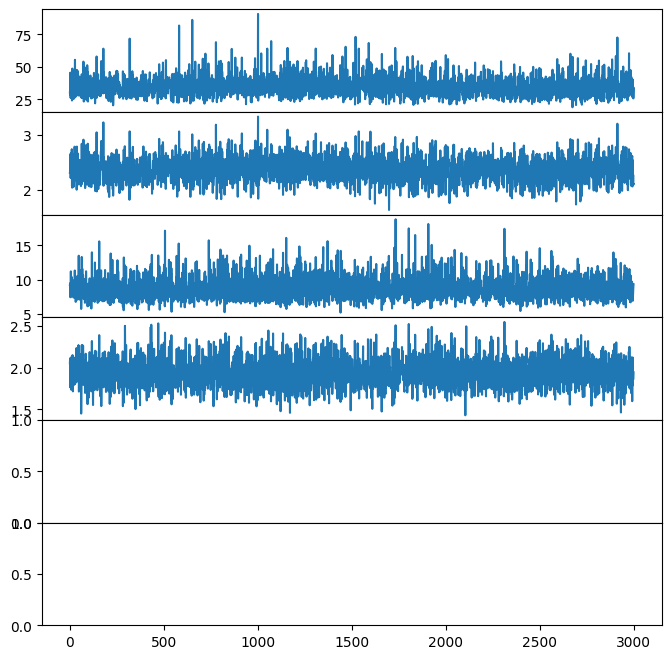

In [30]:
fig, ax = plt.subplots(6,1, sharex=True, figsize=(8,8))
fig.subplots_adjust(hspace=0,wspace=0)

ax[0].plot(flat_samples[:3000,0])
ax[1].plot(flat_samples[:3000,1])
ax[2].plot(flat_samples[:3000,2])
ax[3].plot(flat_samples[:3000,3])
#ax[4].plot(flat_samples[:3000,4])
#ax[5].plot(flat_samples[:3000,5])

(14000, 6)


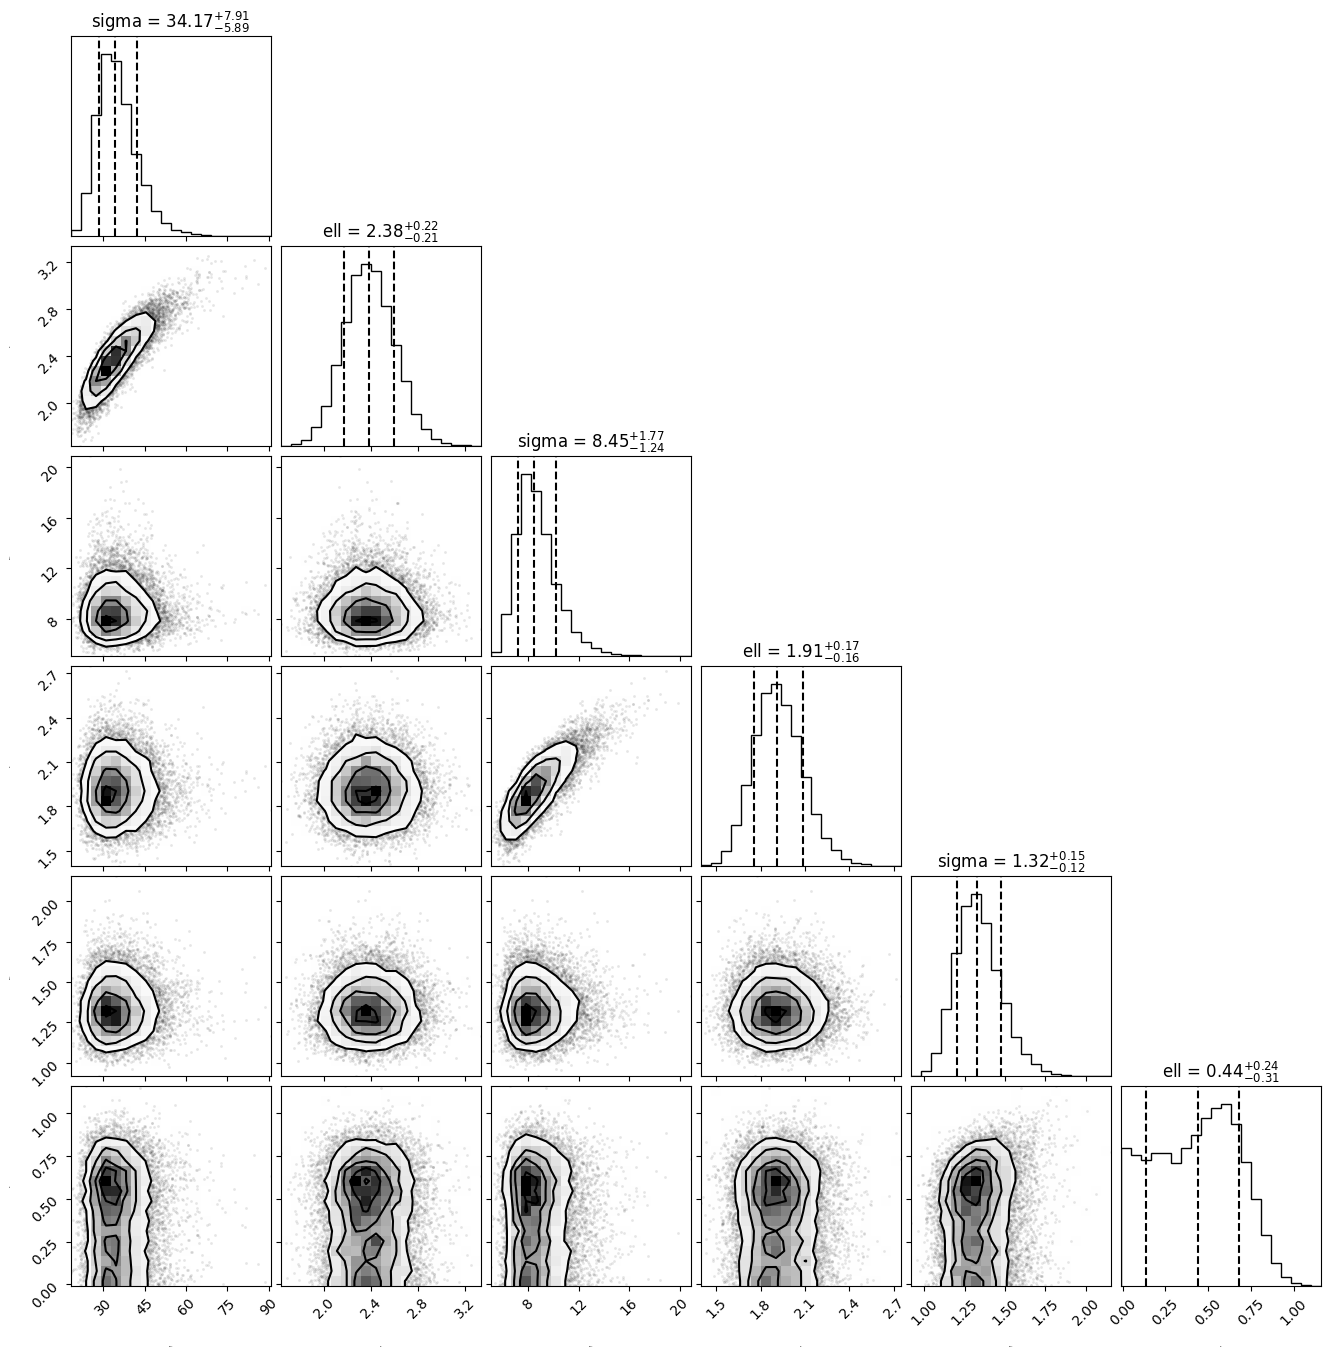

In [31]:
flat_samples = init[-1]
print(flat_samples.shape)
labels = [ "sigma", "ell" ,"sigma", "ell","sigma", "ell","sigma", "ell","sigma", "ell","sigma", "ell","sigma", "ell","sigma", "ell","sigma", \
          "ell","sigma", "ell","sigma", "ell","sigma", "ell","sigma", "ell","sigma", "ell","sigma", "ell"]

fig = corner.corner(
    flat_samples, labels=labels, show_titles=True, quantiles=[0.16, 0.50, 0.84],
                    label_kwargs={'labelpad':20, 'fontsize':0}, fontsize=8
);

## Use the emulator: recover training data

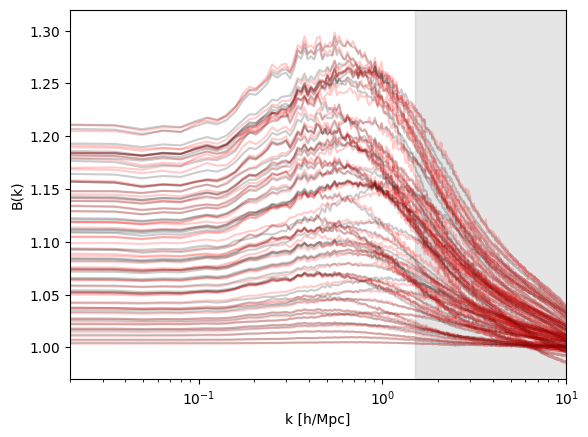

In [37]:
Bk_new = B_k_emu(init, theta_1)

for sim_index in range(len(Bk_new)):
    plt.plot(k_arr, Bk_new[sim_index], 'k', alpha=0.2)
    plt.plot(k_arr, Bk_arr[sim_index, 0, :], 'r', alpha=0.2)

plt.fill_betweenx([0.95,1.32], 1.5, 10, color='gray', alpha=.2)
plt.ylim(0.97,1.32)

f1 = plt.plot([1,1], [1,1], 'k', alpha=0.2, label="data from emulator")
f2 = plt.plot([1,1], [1,1], 'r', alpha=0.2, label="training dataset")
f1 = f1.pop(0)
f2 = f2.pop(0)

f1.remove()
f2.remove()

plt.ylabel("B(k)")
plt.xlim(2e-2,1e1)

plt.xlabel("k [h/Mpc]")
plt.xscale("log")

In [503]:
## Testing emulator for a single point - when it has std also
"""
theta_new = np.array([[0.13,0.8,0.67, 0.96, 2e-9]]).T
print(theta_new)
Bk_new, Bkup, Bklow = B_k_emu(init, theta_new)

# Plot all data to be sure test data is within emulator bounds
df_point = pd.DataFrame(theta_new.T, columns=['wm','f_phi', 'E_dS', 'n_s', 'sigma8'][:len(theta_1)])
sns.pairplot(pd.concat([df_theta.assign(hue='dat'), 
                        df_point.assign(hue='dat2')]), 
             hue='hue', 
             diag_kind='hist',
             palette=['b', 'r'])
#pd.plotting.scatter_matrix(df_theta)
#pd.plotting.scatter_matrix(df_point)
plt.show()

for sim_index in range(1):
    sim_index = 0
    plt.plot(k_arr, Bk_new[sim_index], 'k', alpha=0.7)
    plt.plot(k_arr, Bkup[sim_index], 'b--', alpha=0.2)
    plt.plot(k_arr, Bklow[sim_index], 'b--', alpha=0.2)
    #plt.plot(k_arr, Bk_arr[sim_index, 0, :], 'r', alpha=0.2)

plt.xscale("log")
"""


'\ntheta_new = np.array([[0.13,0.8,0.67, 0.96, 2e-9]]).T\nprint(theta_new)\nBk_new, Bkup, Bklow = B_k_emu(init, theta_new)\n\n# Plot all data to be sure test data is within emulator bounds\ndf_point = pd.DataFrame(theta_new.T, columns=[\'wm\',\'f_phi\', \'E_dS\', \'n_s\', \'sigma8\'][:len(theta_1)])\nsns.pairplot(pd.concat([df_theta.assign(hue=\'dat\'), \n                        df_point.assign(hue=\'dat2\')]), \n             hue=\'hue\', \n             diag_kind=\'hist\',\n             palette=[\'b\', \'r\'])\n#pd.plotting.scatter_matrix(df_theta)\n#pd.plotting.scatter_matrix(df_point)\nplt.show()\n\nfor sim_index in range(1):\n    sim_index = 0\n    plt.plot(k_arr, Bk_new[sim_index], \'k\', alpha=0.7)\n    plt.plot(k_arr, Bkup[sim_index], \'b--\', alpha=0.2)\n    plt.plot(k_arr, Bklow[sim_index], \'b--\', alpha=0.2)\n    #plt.plot(k_arr, Bk_arr[sim_index, 0, :], \'r\', alpha=0.2)\n\nplt.xscale("log")\n'

## Sensitivity analysis from the emulator 

In [504]:
# For each of the parameters, we fix all other parameters to some fiducial values and vary the one parameter linearly

# 'Omega_m','f_phi', 'h', 'n_s', 'A_s'

theta_new1 = np.array([np.linspace(0.225,0.3, 50), np.ones(50)*0.5 , np.ones(50)*0.67, np.ones(50)*0.96, np.ones(50)*2.01e-9])
theta_new2 = np.array([np.ones(50)*0.25, np.linspace(0.0,1.0, 50) , np.ones(50)*0.67, np.ones(50)*0.96, np.ones(50)*2.01e-9])
theta_new3 = np.array([np.ones(50)*0.25, np.ones(50)*0.5 , np.linspace(0.6,0.75, 50), np.ones(50)*0.96, np.ones(50)*2.01e-9])
theta_new4 = np.array([np.ones(50)*0.25, np.ones(50)*0.5 , np.ones(50)*0.67, np.linspace(0.9,1.1, 50), np.ones(50)*2.01e-9])
theta_new5 = np.array([np.ones(50)*0.25, np.ones(50)*0.5 , np.ones(50)*0.67, np.ones(50)*0.96, np.linspace(1.9e-9,3e-9, 50)])


Bk_new1 = B_k_emu(init, theta_new1)
Bk_new2 = B_k_emu(init, theta_new2)
Bk_new3 = B_k_emu(init, theta_new3)
Bk_new4 = B_k_emu(init, theta_new4)
Bk_new5 = B_k_emu(init, theta_new5)


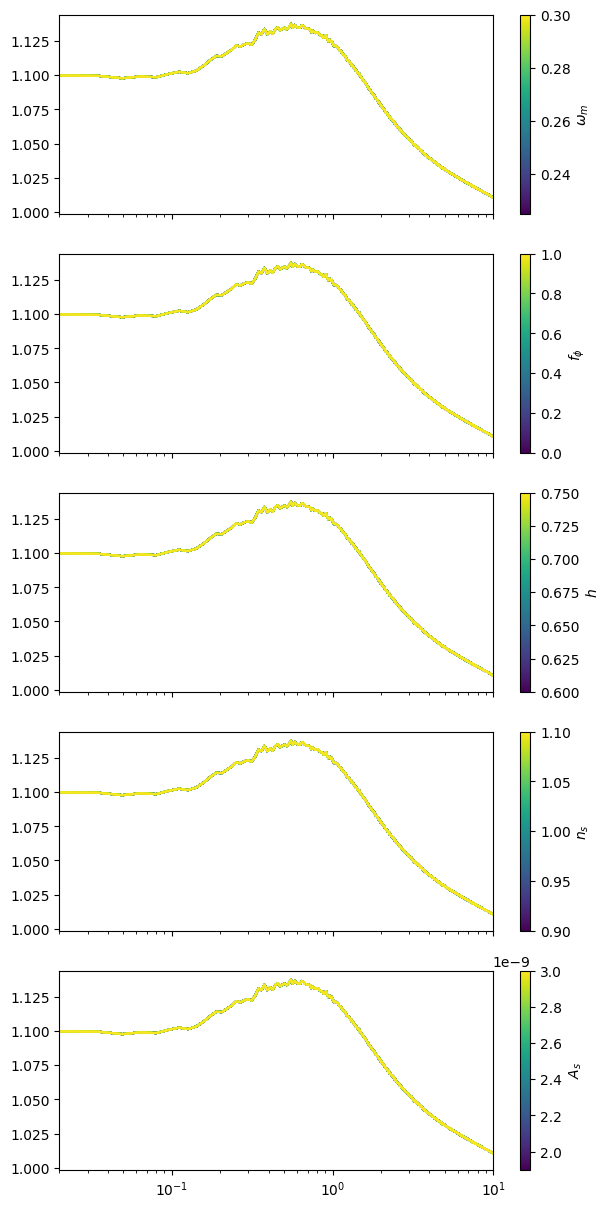

In [505]:
cmap = matplotlib.colormaps['viridis']

f, ax = plt.subplots(5, sharex=True, sharey=False,figsize=(7, 15))

frac1 = (theta_new1[0] - min(theta_new1[0]))/(max(theta_new1[0])-min(theta_new1[0]))
frac2 = (theta_new2[1] - min(theta_new2[1]))/(max(theta_new2[1])-min(theta_new2[1]))
frac3 = (theta_new3[2] - min(theta_new3[2]))/(max(theta_new3[2])-min(theta_new3[2]))
frac4 = (theta_new4[3] - min(theta_new4[3]))/(max(theta_new4[3])-min(theta_new4[3]))
frac5 = (theta_new5[4] - min(theta_new5[4]))/(max(theta_new5[4])-min(theta_new5[4]))

for sim_index in range(50):
    ax[0].plot(k_arr, Bk_new1[sim_index], color = cmap(frac1[sim_index]), alpha=0.7)
    ax[1].plot(k_arr, Bk_new2[sim_index], color = cmap(frac2[sim_index]), alpha=0.7)
    ax[2].plot(k_arr, Bk_new3[sim_index], color = cmap(frac3[sim_index]), alpha=0.7)
    ax[3].plot(k_arr, Bk_new4[sim_index], color = cmap(frac4[sim_index]), alpha=0.7)
    ax[4].plot(k_arr, Bk_new5[sim_index], color = cmap(frac5[sim_index]), alpha=0.7)
    #plt.plot(k_arr, Bk_arr[sim_index, 0, :], 'r', alpha=0.2)
plt.xscale("log")

norm = matplotlib.colors.Normalize(vmin=min(theta_new1[0]), vmax=max(theta_new1[0]))
f.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), ax = ax[0], orientation='vertical', label=r'$\omega_m$')
norm = matplotlib.colors.Normalize(vmin=min(theta_new2[1]), vmax=max(theta_new2[1]))
f.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), ax = ax[1], orientation='vertical', label=r'$f_{\phi}$')
norm = matplotlib.colors.Normalize(vmin=min(theta_new3[2]), vmax=max(theta_new3[2]))
f.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), ax = ax[2], orientation='vertical', label=r'$h$')
norm = matplotlib.colors.Normalize(vmin=min(theta_new4[3]), vmax=max(theta_new4[3]))
f.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), ax = ax[3], orientation='vertical', label=r'$n_s$')
norm = matplotlib.colors.Normalize(vmin=min(theta_new5[4]), vmax=max(theta_new5[4]))
f.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), ax = ax[4], orientation='vertical', label=r'$A_s$')


ax[0].set_xlim(2e-2,1e1)
plt.show()

## Thinking of validation data points

In [728]:
""" We have:
0.27 ≤ Ωm ≤ 0.33
0.85 ≤ ns ≤ 1.1
1.45e-09 ≤ As ≤ 3.3e-09
0.61 ≤ h ≤ 0.73
0 ≤ f_phi ≤ 1

we want order: 'Omega_m','n_s', 'A_s', 'h', 'f_phi'

We want some data that is very concentrated about the edges and the GR points - that means f_phi sampled at 0 and 1 , and P_cosm0 at the centre, at 0 and 1?
"""
Omg_m_min = 0.27
Omg_m_max = 0.33
Omg_m_fid = 0.315

ns_min = 0.85
ns_max =1.1
ns_fid = 0.96

As_min = 1.45e-9
As_max = 3.3e-9
As_fid = 2.01e-9

h_min = 0.61
h_max = 0.73
h_fid = 0.67


sampler = scipy.stats.qmc.LatinHypercube(5, strength=2, seed=100,scramble=False)
sample = sampler.random(n=49).T


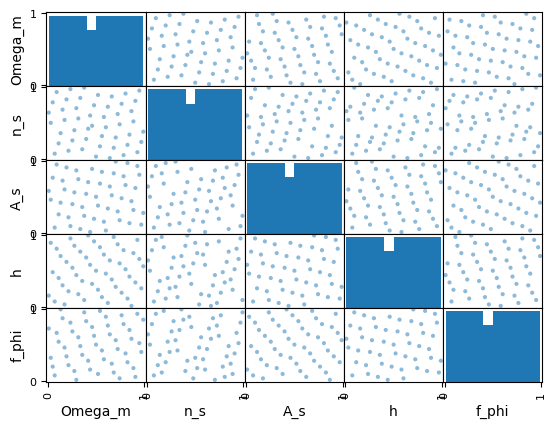

In [729]:

sample_pd = pd.DataFrame(sample.T, columns=['Omega_m','n_s', 'A_s', 'h', 'f_phi'][:len(sample)])

pd.plotting.scatter_matrix(sample_pd)
plt.show()

In [701]:
"""f_phi resampling"""

# Investigating even power sampling
# validat_array
power = 0.4

fphi_new = np.sign(sample[4] - 0.5) * np.abs(sample[4] - 0.5)**power /0.5**(power-1) + 0.5

Text(0.5, 0, '$f_{\\phi}$')

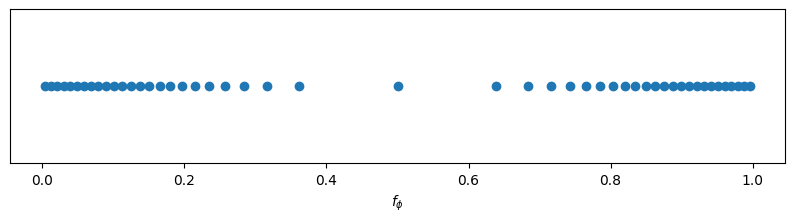

In [702]:
fig, ax = plt.subplots(1,1, sharex = True, sharey=True)
fig.set_size_inches(10,2)

ax.scatter(fphi_new,
           np.ones(len(sample[4])))

ax.axes.get_yaxis().set_ticks([])
ax.set_xlabel(r"$f_{\phi}$")



In [703]:
"""Define useful functions for cubic sampling"""

# Takes in a sample spaced between [0,1] and returns a sample rescaled between [new_min,new_max]
def rescale(x, new_min, new_max):
    return x * (new_max - new_min) + new_min
    
# Takes in a sample x in [0,1] and returns a sample rescaled between [0,width_lower], with a quadratic sampling
def bias_scaling_funct1(x, power, width_lower):
    width_upper = 1 - width_lower
    return np.sign(x - 0.5) * np.abs(x - 0.5)**power/(0.5**power) * width_lower/2 + width_lower/2

# Takes in a sample x in [0,1] and returns a sample rescaled between [width_lower, 1], with a quadratic sampling
def bias_scaling_funct2(x, power, width_lower):
    width_upper = 1 - width_lower
    return np.sign(x - 0.5) * np.abs(x - 0.5)**power/(0.5**power) * width_upper/2 + width_upper/2 + width_lower


In [715]:
"""Omega_m resampling"""

# Investigating cubic sampling

#0.27 ≤ Ωm ≤ 0.33
#Omg_m_fid = 0.315

power = 0.3

Omg_m1 = bias_scaling_funct1(sample[0], power, (Omg_m_fid - Omg_m_min) / (Omg_m_max - Omg_m_min))
Omg_m2 = bias_scaling_funct2(sample[0], power, (Omg_m_fid - Omg_m_min) / (Omg_m_max - Omg_m_min))

print((Omg_m_fid - Omg_m_min) / (Omg_m_max - Omg_m_min))
print(rescale((Omg_m_fid - Omg_m_min) / (Omg_m_max - Omg_m_min), Omg_m_min, Omg_m_max))

"""print(np.min(Omg_m1))
print(np.max(Omg_m1))
print(np.min(Omg_m2))
print(np.max(Omg_m2))"""

0.7499999999999998
0.315


'print(np.min(Omg_m1))\nprint(np.max(Omg_m1))\nprint(np.min(Omg_m2))\nprint(np.max(Omg_m2))'

0.7476874899099575
0.7507708366966805


Text(0.5, 0, '$f_{\\phi}$')

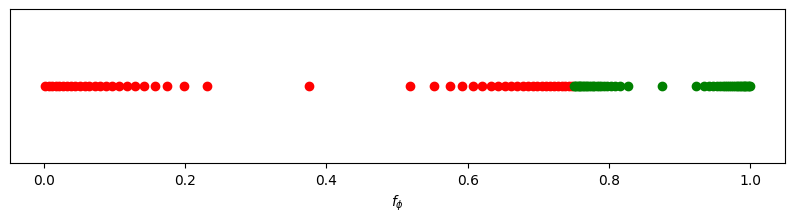

In [716]:
fig, ax = plt.subplots(1,1, sharex = True, sharey=True)
fig.set_size_inches(10,2)

ax.scatter((Omg_m1),
           np.ones(len(sample[0])), color="r")
ax.scatter((Omg_m2),
           np.ones(len(sample[0])), color="g")

print(np.max(Omg_m1))
print(np.min(Omg_m2))

ax.axes.get_yaxis().set_ticks([])
ax.set_xlabel(r"$f_{\phi}$")



0.0023125100900423523
0.7476874899099575
0.7507708366966805
0.9992291633033192


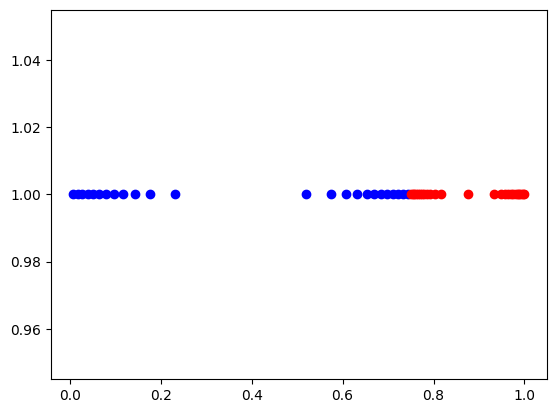

In [717]:
# get list in index of f_phi in increasing order of f_phi

def sort_by_indexes(lst, indexes, reverse=False):
    return [val for (_, val) in sorted(zip(indexes, lst), key=lambda x: \
          x[0], reverse=reverse)]
    
indx_Omg_m = np.arange(0,len(sample[0]))

newsort = sort_by_indexes(indx_Omg_m, sample[0])

odd_i = []
even_i = []
for i in range(0, len(newsort)):
    if i % 2:
        even_i.append(newsort[i])
    else :
        odd_i.append(newsort[i])

# get list in index of f_phi in increasing order of f_phi

Omg_m_new_evenspace = Omg_m1
Omg_m_new_oddspace = Omg_m2

sample_new_double = []
for i in range(0, len(Omg_m_new_evenspace)):
    if i in odd_i:
        plt.scatter(Omg_m_new_oddspace[i], 1, color="r")
        sample_new_double.append(Omg_m_new_oddspace[i])
    else:
        plt.scatter(Omg_m_new_evenspace[i], 1, color="b")
        sample_new_double.append(Omg_m_new_evenspace[i])
        
print(np.min(Omg_m_new_evenspace))
print(np.max(Omg_m_new_evenspace))
print(np.min(Omg_m_new_oddspace))
print(np.max(Omg_m_new_oddspace))

Text(0.5, 0, '$f_{\\phi}$')

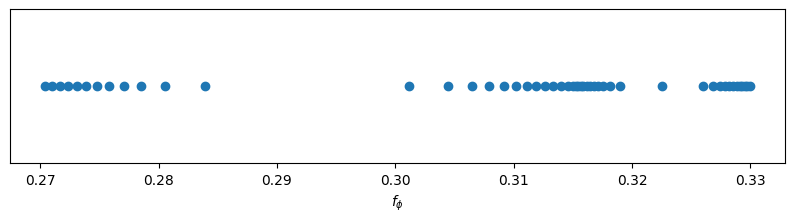

In [718]:
fig, ax = plt.subplots(1,1, sharex = True, sharey=True)
fig.set_size_inches(10,2)

Omg_m_new = rescale(np.array(sample_new_double), Omg_m_min, Omg_m_max)
ax.scatter((Omg_m_new),
           np.ones(len(sample[0])))

ax.axes.get_yaxis().set_ticks([])
ax.set_xlabel(r"$f_{\phi}$")



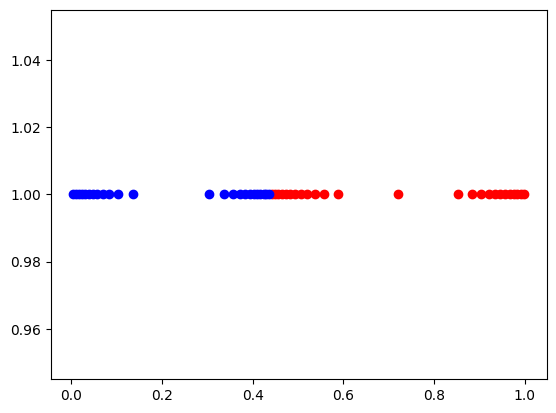

In [719]:
"""ns resampling"""

#ns_min = 0.85
#ns_max =1.1
#ns_fid = 0.96

ns1 = bias_scaling_funct1(sample[1], power, (ns_fid - ns_min) / (ns_max - ns_min))
ns2 = bias_scaling_funct2(sample[1], power, (ns_fid - ns_min) / (ns_max - ns_min))

indx_ns = np.arange(0,len(sample[1]))

newsort = sort_by_indexes(indx_ns, sample[1])

odd_i = []
even_i = []
for i in range(0, len(newsort)):
    if i % 2:
        even_i.append(newsort[i])
    else :
        odd_i.append(newsort[i])

# get list in index of f_phi in increasing order of f_phi

ns_new_evenspace = ns1
ns_new_oddspace = ns2

sample_new_double = []
for i in range(0, len(ns_new_evenspace)):
    if i in odd_i:
        plt.scatter(ns_new_oddspace[i], 1, color="r")
        sample_new_double.append(ns_new_oddspace[i])
    else:
        plt.scatter(ns_new_evenspace[i], 1, color="b")
        sample_new_double.append(ns_new_evenspace[i])
        
ns_new = rescale(np.array(sample_new_double), ns_min, ns_max)

Text(0.5, 0, '$f_{\\phi}$')

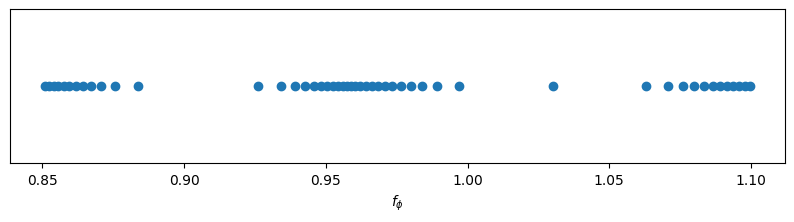

In [720]:
fig, ax = plt.subplots(1,1, sharex = True, sharey=True)
fig.set_size_inches(10,2)

ax.scatter((ns_new),
           np.ones(len(sample[1])))

ax.axes.get_yaxis().set_ticks([])
ax.set_xlabel(r"$f_{\phi}$")


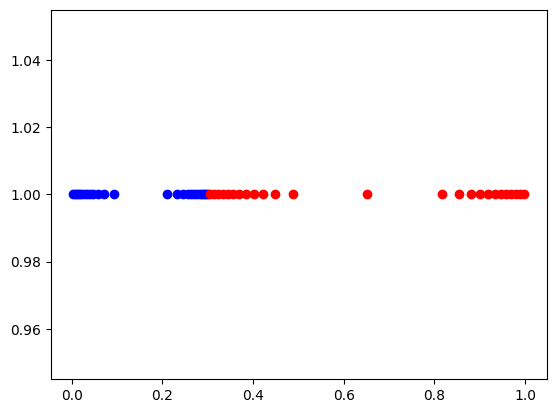

In [721]:
"""As resampling"""

#As_min = 1.45e-9
#As_max = 3.3e-9
#As_fid = 2.01e-9

As1 = bias_scaling_funct1(sample[2], power, (As_fid - As_min) / (As_max - As_min))
As2 = bias_scaling_funct2(sample[2], power, (As_fid - As_min) / (As_max - As_min))

indx_As = np.arange(0,len(sample[2]))

newsort = sort_by_indexes(indx_As, sample[2])

odd_i = []
even_i = []
for i in range(0, len(newsort)):
    if i % 2:
        even_i.append(newsort[i])
    else :
        odd_i.append(newsort[i])

# get list in index of f_phi in increasing order of f_phi

As_new_evenspace = As1
As_new_oddspace = As2

sample_new_double = []
for i in range(0, len(As_new_evenspace)):
    if i in odd_i:
        plt.scatter(As_new_oddspace[i], 1, color="r")
        sample_new_double.append(As_new_oddspace[i])
    else:
        plt.scatter(As_new_evenspace[i], 1, color="b")
        sample_new_double.append(As_new_evenspace[i])
        
As_new = rescale(np.array(sample_new_double), As_min, As_max)

Text(0.5, 0, '$f_{\\phi}$')

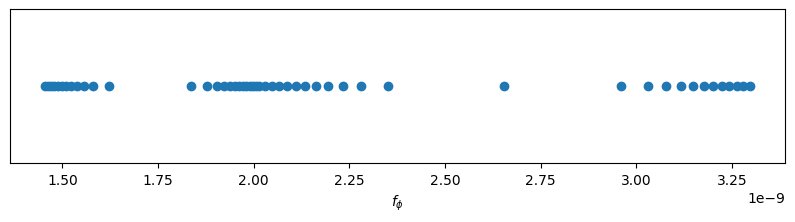

In [722]:
fig, ax = plt.subplots(1,1, sharex = True, sharey=True)
fig.set_size_inches(10,2)

ax.scatter((As_new),
           np.ones(len(sample[1])))

ax.axes.get_yaxis().set_ticks([])
ax.set_xlabel(r"$f_{\phi}$")


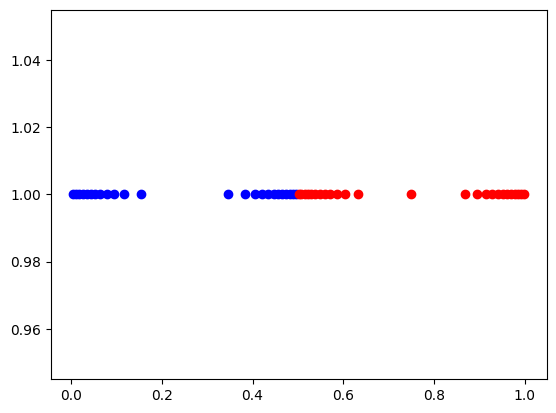

In [723]:
"""h resampling"""

#h_min = 0.61
#h_max = 0.73
#h_fid = 0.67

h1 = bias_scaling_funct1(sample[3], power, (h_fid - h_min) / (h_max - h_min))
h2 = bias_scaling_funct2(sample[3], power, (h_fid - h_min) / (h_max - h_min))

indx_h = np.arange(0,len(sample[3]))

newsort = sort_by_indexes(indx_h, sample[3])

odd_i = []
even_i = []
for i in range(0, len(newsort)):
    if i % 2:
        even_i.append(newsort[i])
    else :
        odd_i.append(newsort[i])

# get list in index of f_phi in increasing order of f_phi

h_new_evenspace = h1
h_new_oddspace = h2

sample_new_double = []
for i in range(0, len(h_new_evenspace)):
    if i in odd_i:
        plt.scatter(h_new_oddspace[i], 1, color="r")
        sample_new_double.append(h_new_oddspace[i])
    else:
        plt.scatter(h_new_evenspace[i], 1, color="b")
        sample_new_double.append(h_new_evenspace[i])
        
h_new = rescale(np.array(sample_new_double), h_min, h_max)

Text(0.5, 0, '$f_{\\phi}$')

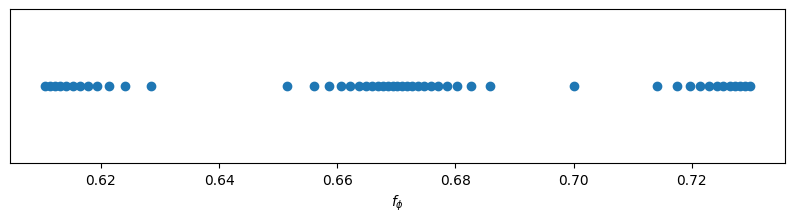

In [724]:
fig, ax = plt.subplots(1,1, sharex = True, sharey=True)
fig.set_size_inches(10,2)

ax.scatter((h_new),
           np.ones(len(sample[3])))

ax.axes.get_yaxis().set_ticks([])
ax.set_xlabel(r"$f_{\phi}$")


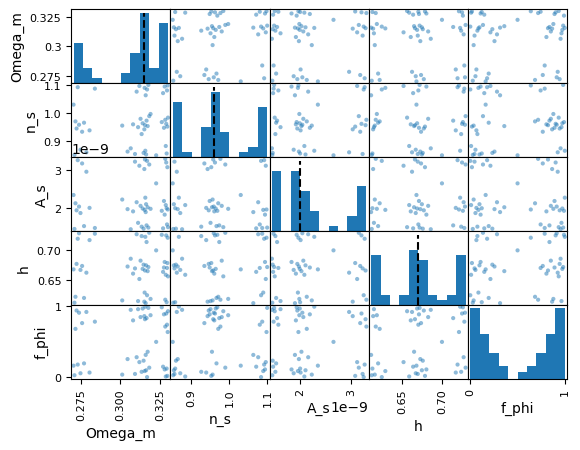

In [751]:
sample_new = pd.DataFrame(np.array([Omg_m_new, ns_new, As_new,h_new, fphi_new]).T, columns=['Omega_m','n_s', 'A_s', 'h', 'f_phi'][:len(sample)])
arr_center = np.array([Omg_m_fid, ns_fid, As_fid,h_fid])
axs = pd.plotting.scatter_matrix(sample_new)

for i in range(len(axs)-1): # the left boundary
    axs[i,i].plot([arr_center[i], arr_center[i]], [0.0, 14.0], "k--")

plt.show()

## Use the emulator: get validation datasets

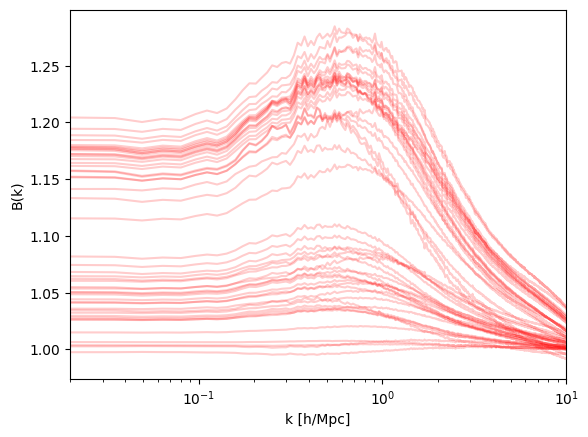

In [736]:
theta_val = np.array([Omg_m_new, ns_new, As_new,h_new, fphi_new])
Bk_val = B_k_emu(init, theta_val)

for sim_index in range(len(Bk_val)):
    plt.plot(k_arr, Bk_val[sim_index], 'r', alpha=0.2)
    #plt.plot(k_arr, Bk_arr[sim_index, 0, :], 'r', alpha=0.2)

#f1 = plt.plot([1,1], [1,1], 'k', alpha=0.2, label="data from emulator")
#f2 = plt.plot([1,1], [1,1], 'r', alpha=0.2, label="training dataset")
#f1 = f1.pop(0)
#f2 = f2.pop(0)

#f1.remove()
#f2.remove()

plt.ylabel("B(k)")
plt.xlim(2e-2,1e1)

plt.xlabel("k [h/Mpc]")
plt.xscale("log")